# Pulse Optimized Scrambling Demo

Reference: *Optimized Quantum Compilation for Near-Term Algorithms with OpenPulse* arXiv:2004.11205

Source code: https://github.com/singular-value/optimizations_via_openpulse

In [12]:
# general imports:
%matplotlib inline
import matplotlib, qiskit, pprint, itertools
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, IBMQ, transpile, schedule, assemble
from qiskit.circuit import *
from qiskit.circuit.library.standard_gates import *
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeAlmaden, FakeMontreal, FakeMelbourne
from qiskit.visualization import *
from qiskit.circuit.library import *
from qiskit import pulse

In [13]:
# import utils for Quantum Information Scrambling Verification Test:
from QSVT_utils import *

In [14]:
# load account:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# get simulator:
f_mel = FakeMelbourne()
f_alma = FakeAlmaden() # simulator f_alma for pulse schedules
f_mon = FakeMontreal()

ibmqfactory.load_account:WARNING:2021-06-01 18:43:58,464: Credentials are already in use. The existing account in the session will be replaced.


# Mapping

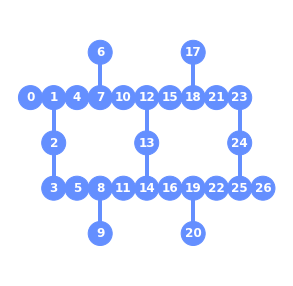

In [15]:
backend = f_mon # set simulator

# get defaults and instruction schedule map 
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 

plot_gate_map(backend)

In [16]:
# mapping
q0, q1, q2, q3, q4, q5, q6 = 3, 5, 8, 11, 14, 13, 12

# num of qubits scrambling unitary operates on
n = 3

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# initial bell pair inums defining the many-body-system
bell_pairs = [[q2, q3], [q1, q4], [q5, q6]]

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = q0, q6

# define qubit pair that will be used for base measurement 
basemeas = [q2, q3]

# let's also store our clever map to a list
initial_layout = [q0, q1, q2, q3, q4, q5, q6]

# CR(theta) shedules

Now, let's get the cross resonance pulses we are going to use in our scrambling protocol instead of the two-qubit-gates we used when working on the ciruit level.

Reference for CR(theta) pulse schedules: 
- **Optimized Quantum Compilation for Near-Term Algorithms with OpenPulse** [arXiv:2004.11205](https://arxiv.org/abs/2004.11205), Source code: https://github.com/singular-value/optimizations_via_openpulse

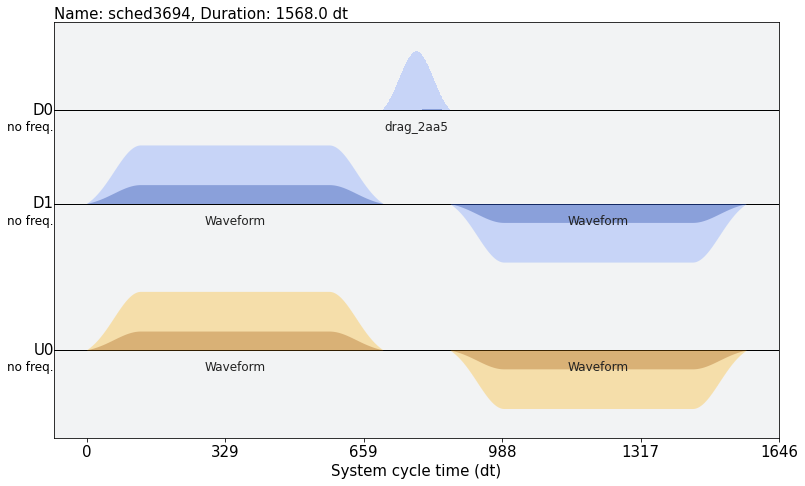

In [17]:
# tunable parameter alpha
alpha = 1

# corresponding angles
theta = get_theta_from_alpha(1)
beta = get_theta_from_alpha(alpha)

# get dict with control channels and cr pulses for all coupled pairs
CR_dict = get_CR_dict(theta, backend)

# let's take a loon one of those CR(theta) schedules!
CR_dict.get((0,1)).draw()

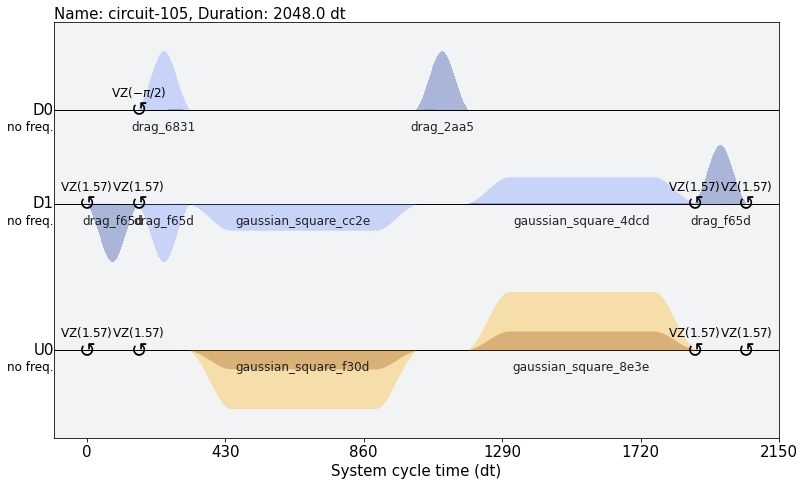

In [18]:
# let's make a new test circuit to compare our CR(theta) schedule 
# with the one we'd get working with a CZ gate on the circuit level
from qiskit import schedule

testcirc = QuantumCircuit(2,2)
testcirc.cz(0,1)
transpiled_testcirc = transpile(testcirc,backend)
# let's see it!
schedule(transpiled_testcirc,backend).draw()

Perfect! Our CR(theta) schedule looks much cleaner, because it skips some of the extra rotations coming from building the CZ from the CX basis gate. Also the duration is shorter. If the scrambling experiments you have in mind takes interest in durations, taking it to the pulse level also provides you with a handy method to extract the actual pulse durations of your scrambling pulses.

In [19]:
# dict with coupled qubits as keys and CR(theta) schedule durations as values
CR_duration_dict = dict(zip([x for x in CR_dict.keys()],
                            [x.duration for x in CR_dict.values()]))

# test the first:
print("Duration for CR(theta) pulse and qubits 0 and 1:\t", CR_duration_dict.get((0,1)),"dt")

# you may convert from dt to ns like such:
dt_in_ns = dt*1e9
print("Duration for CR(theta) pulse and qubits 0 and 1:\t", round(dt_in_ns*CR_duration_dict.get((0,1)),2),"ns")

Duration for CR(theta) pulse and qubits 0 and 1:	 1568 dt
Duration for CR(theta) pulse and qubits 0 and 1:	 348.44 ns


#  Framing Schedules

To combine the optimized schedules of CR(theta) and RX(theta) pulses with schedules for the initial entanglement of EPR pairs, schedules for eventually necessary SWAPs between quibits, that aren't direct neighbors, as well as the disentanglement and decoding at the end of the protocol, we can first transpile those circuit parts and save those framing schedules.

In [ ]:
# setup circs
cr = ClassicalRegister(qnum)
qr = QuantumRegister(qnum)
circ = QuantumCircuit(qr,cr)
# transpile it to match our clever layout
transpiled_circ = transpile(circ, backend, initial_layout=initial_layout)

In [ ]:
# actually, let's quickly put that into a func 
def get_transpiled_circ(backend, initial_layout):
    qnum = len(initial_layout)
    cr = ClassicalRegister(qnum)
    qr = QuantumRegister(qnum)
    circ = QuantumCircuit(qr,cr)
    transpiled_circ = transpile(circ, backend, initial_layout=initial_layout)
    return transpiled_circ

In [27]:
# now we setup the circuits we will transform to schedules
start_circ = get_transpiled_circ(backend, initial_layout)
end_circ = get_transpiled_circ(backend, initial_layout)
swap_circ_up = get_transpiled_circ(backend, initial_layout)
swap_circ_low = get_transpiled_circ(backend, initial_layout)

# apply all the gates we need on all those circs:

# 1. start circ
for pair in bell_pairs:
    start_circ.h(pair[0])
    start_circ.cx(pair[0],pair[1])

# 2. end circ
end_circ.cx(q2,q3)
end_circ.h(q2)
end_circ.cx(q3,q6)
end_circ.cz(q2,q6)
end_circ.measure_all()

# 3. + 4. swap circs
swap_circ_up.swap(q1,q2)
swap_circ_low.swap(q3,q4)

# transpile them all 
end_circ_tr = transpile(end_circ, backend)
start_circ_tr = transpile(start_circ, backend)
swap_circ_up_tr = transpile(swap_circ_up, backend)
swap_circ_low_tr = transpile(swap_circ_low, backend)

# and finally get all our framing schedules
from qiskit import schedule
start_sched = schedule(start_circ_tr,backend)
end_sched = schedule(end_circ_tr,backend)
swap_up_sched = schedule(swap_circ_up_tr,backend)
swap_low_sched = schedule(swap_circ_up_tr,backend)

# Schedule Experiments

In the main schedule we can now combine our optimized CR(theta) and RX(theta) pulses with the framing pulses we did first. 
Of course also the framing schedules could be further optimized using pulse techniques, you can find all about that in the [Qiskit Textbook, Chapter 5: Investigating Quantum Hardware Using Quantum Circuits](https://qiskit.org/textbook/ch-quantum-hardware/index-circuits.html). In this example, let's just focus on how our scrambling schedules can easily be combined to an experimental setup.

## Experiment A: CR(theta) and Pi-Pulse tunable scrambling

Let's assume we'd like to setup a tunable scrambling schedule like the one we saw in the [Tunable Scrambling Circuit Demo](Demo_TunableScramblingCircuit.ipynb). Here a quick reminder what the circuit looked like in the [original paper](https://arxiv.org/abs/1806.02807):
![tunable](.\\pics\\Telpo3_Tunable_Scrambling_Circ_small.jpg)

The idea of this circuit is basically, to tune the srambling by detuning the single qubit rotation angles from the ±pi/4 angles of the entangling XX gates.

If you'd just like to do a pulse optimized schedule analog to this circuit, we can simply set theta to ±pi/4. To easily get the schedules for plus and minus rotations, let's first store the corresponding CR pulsesin two dictionaries.

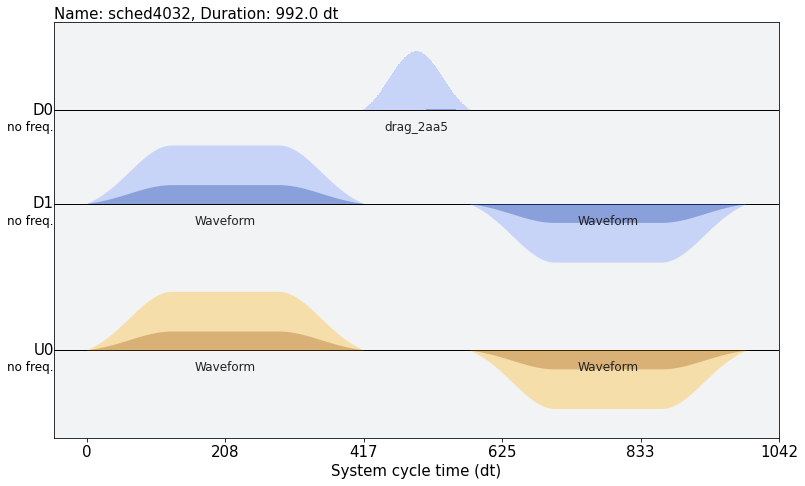

In [28]:
# our plus and minus angles
theta_plus = pi/4
theta_minus = -pi/4

# get both dicts with control channels and cr pulses for all coupled pairs
CR_dict_plus = get_CR_dict(theta_plus, backend)
CR_dict_minus = get_CR_dict(theta_minus, backend)

# let's see what the first plus pi/4 schedule looks like:
CR_dict_plus.get((0,1)).draw()

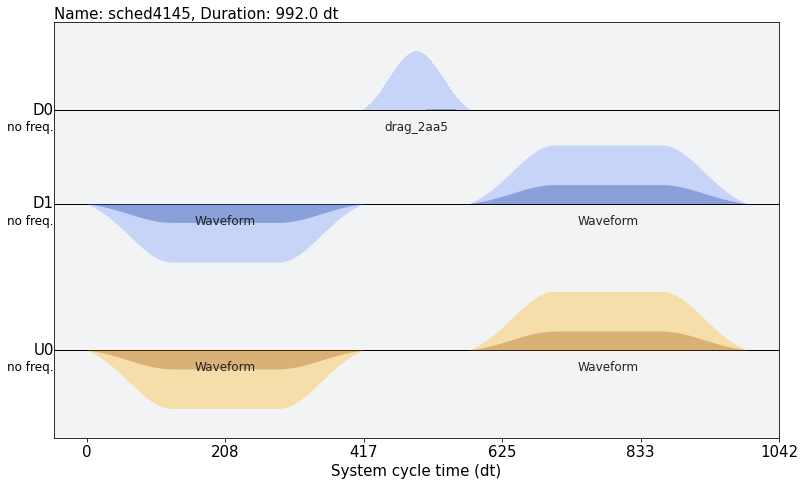

In [29]:
# and here the corresponding minus pi/4 version:
CR_dict_minus.get((0,1)).draw()

This looks beatiful. Now let's also store the single qubit rotation pulses for plus and minus theta. Actually those scheds are going to be without any pulses played, because those are "virtual gates". Let's take a look what that actuall looks like!

In [45]:
# let's make our lazy selfs a quick func to get rz scheds
# you could easly rewrite it to apply some other gates instead

def get_rz_sched(theta, qubit, backend, initial_layout):
    from qiskit import schedule
    circ = get_transpiled_circ(backend, initial_layout)
    # just put your gates here if you want to use othes:
    circ.rz(theta, qubit)
    # and get the sched:
    tc = transpile(circ,backend)
    sched = schedule(tc,backend)    
    return sched
    
# let's try it 
print("\nRZ(+theta) schedule for q0:\n", get_rz_sched(theta, q0, backend, initial_layout))


RZ(+theta) schedule for q0:
 Schedule((0, ShiftPhase(-1.5707963267949, DriveChannel(3))), (0, ShiftPhase(-1.5707963267949, ControlChannel(10))), (0, ShiftPhase(-1.5707963267949, ControlChannel(5))), name="circuit-284")


**Awesome! Now we are ready to go ahead and build the tunable srambling schedule!**

### Experiment A: Main Schedule

In the first step, let's just ignore all those framing schedules plus swappings we gonna have to make and just make comments instead, so we can get a clear sight of our pure scrambling pulses.

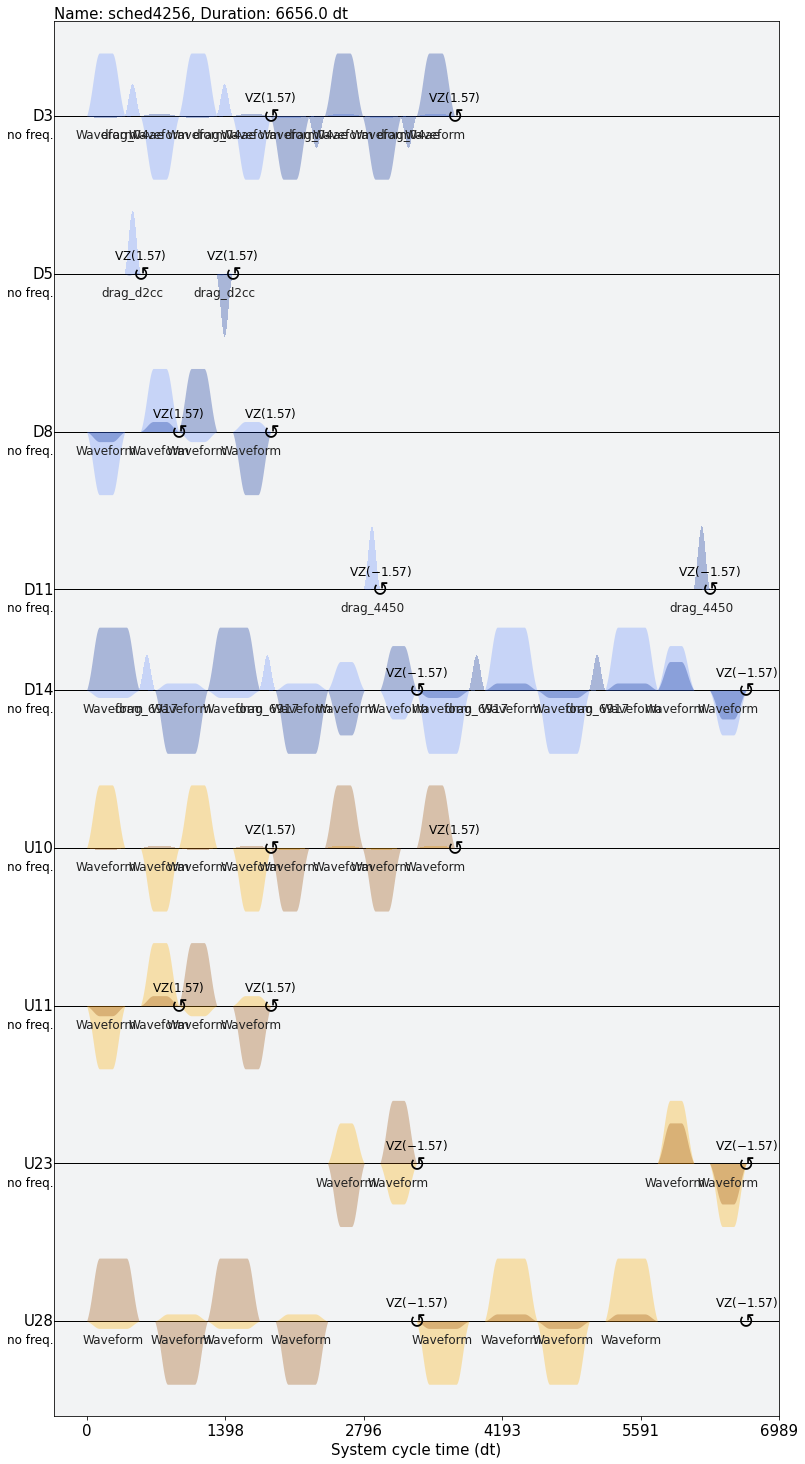

In [46]:
# a plain new schedule
main_sched = Schedule()

#######################################################
# 1. start_sched comes here
#######################################################
# 2. first swapping comes here
#######################################################

# CR(theta) for outer qubit pairs
main_sched += CR_dict_plus.get((q0,q1))
main_sched += CR_dict_minus.get((q4,q5))

#######################################################
# 3. first back swapping comes here
#######################################################

# repeat CR(theta) for outer qubit and direct neighbors
main_sched += CR_dict_plus.get((q0,q1))
main_sched += CR_dict_minus.get((q4,q5))

# repeat CR(theta) for inner qubit and direct neighbors
main_sched += CR_dict_plus.get((q1,q2))
main_sched += CR_dict_minus.get((q3,q4))

# apply single-qubit rotations
for q in [q0,q1,q2]:
    main_sched += get_rz_sched(theta, q, backend, initial_layout)

for q in [q3,q4,q5]:
    main_sched += get_rz_sched(-theta, q, backend, initial_layout)
    
#######################################################
# 4. second swapping comes here 
#######################################################

# CR(theta) for outer qubit pairs
main_sched += CR_dict_plus.get((q0,q1))
main_sched += CR_dict_minus.get((q4,q5))

#######################################################
# 5. second back swapping comes here
#######################################################

# repeat CR(theta) for outer qubit and direct neighbors
main_sched += CR_dict_plus.get((q0,q1))
main_sched += CR_dict_minus.get((q4,q5))

# repeat CR(theta) for inner qubit and direct neighbors
main_sched += CR_dict_plus.get((q1,q2))
main_sched += CR_dict_minus.get((q3,q4))

# apply single-qubit rotations
for q in [q0,q1,q2]:
    main_sched += get_rz_sched(theta, q, backend, initial_layout)

for q in [q3,q4,q5]:
    main_sched += get_rz_sched(-theta, q, backend, initial_layout)
    
#######################################################
# 6. end_sched comes here
#######################################################   
    
main_sched.draw()

Beautiful!

Just to get a complete run through this example, let's also get those framings scheds into the full main schedule now.

In [47]:
# a plain new schedule
main_sched = Schedule()

#######################################################
# 1. start_sched comes here
main_sched += start_sched
#######################################################
# 2. first swapping comes here
main_sched += swap_up_sched
main_sched += swap_low_sched
#######################################################

# CR(theta) for outer qubit pairs
main_sched += CR_dict_plus.get((q0,q1))
main_sched += CR_dict_minus.get((q4,q5))

#######################################################
# 3. first back swapping comes here
main_sched += swap_up_sched
main_sched += swap_low_sched
#######################################################

# repeat CR(theta) for outer qubit and direct neighbors
main_sched += CR_dict_plus.get((q0,q1))
main_sched += CR_dict_minus.get((q4,q5))

# repeat CR(theta) for inner qubit and direct neighbors
main_sched += CR_dict_plus.get((q1,q2))
main_sched += CR_dict_minus.get((q3,q4))

# apply single-qubit rotations
for q in [q0,q1,q2]:
    main_sched += get_rz_sched(theta, q, backend, initial_layout)

for q in [q3,q4,q5]:
    main_sched += get_rz_sched(-theta, q, backend, initial_layout)
    
#######################################################
# 4. second swapping comes here 
main_sched += swap_up_sched
main_sched += swap_low_sched
#######################################################

# CR(theta) for outer qubit pairs
main_sched += CR_dict_plus.get((q0,q1))
main_sched += CR_dict_minus.get((q4,q5))

#######################################################
# 5. second back swapping comes here
main_sched += swap_up_sched
main_sched += swap_low_sched
#######################################################

# repeat CR(theta) for outer qubit and direct neighbors
main_sched += CR_dict_plus.get((q0,q1))
main_sched += CR_dict_minus.get((q4,q5))

# repeat CR(theta) for inner qubit and direct neighbors
main_sched += CR_dict_plus.get((q1,q2))
main_sched += CR_dict_minus.get((q3,q4))

# apply single-qubit rotations
for q in [q0,q1,q2]:
    main_sched += get_rz_sched(theta, q, backend, initial_layout)

for q in [q3,q4,q5]:
    main_sched += get_rz_sched(-theta, q, backend, initial_layout)
    
#######################################################
# 6. end_sched comes here
#######################################################   
main_sched += end_sched 

#### That's it! That was fun! Let's take a look.

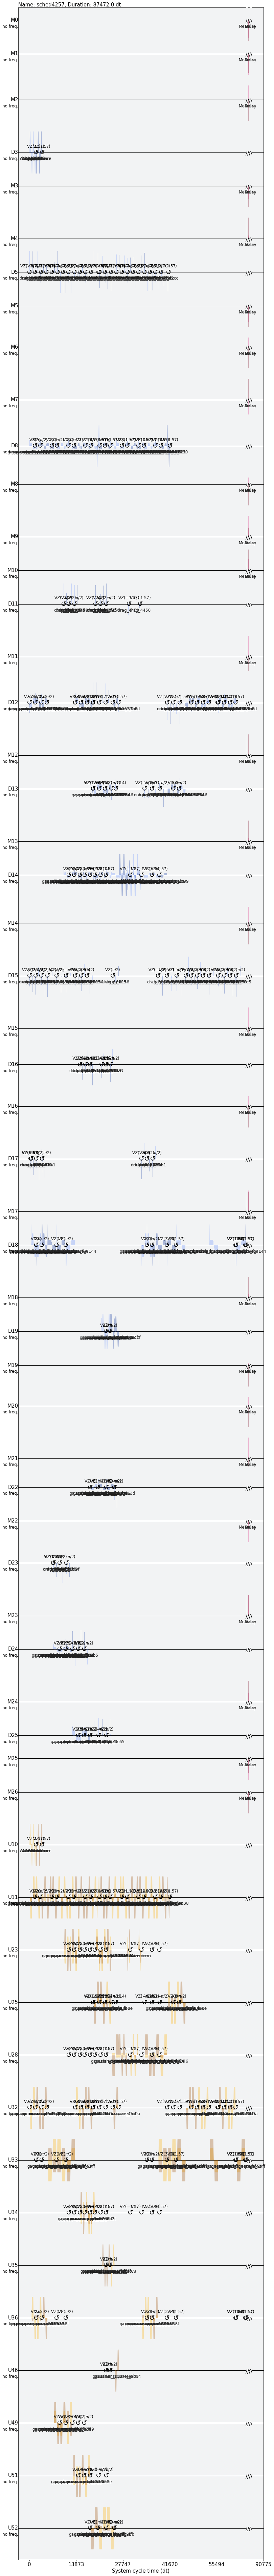

In [48]:
main_sched.draw()

## Experiment B: Combination of different theta values for CR pulses

Let's get fancy now and build a schedule using different degrees of entanglement for different pairings! We are going to give those qubits, that aren't direct neighbors (and thus are "furthes neighbors") a fully entangling CR(pi/2) and those ones that are actual neighbors on the device just a CR(pi/4)!

Let's skip the swappings and framing schedules again for now.

We will asically proceed as we did in our Tunable Scrambling Circuit Demo. 

Quick reminder what that scramblibg circuit looked like:
![tunable](./pics/Tunable_Scrambling_Circuit.png)


**But instead of CZ gates everywhere, we will combine CR(pi/2) and CR(pi/4) as previously promised. So let's go through that!**

In [71]:
# dict with CR(pi/2) schedules
CR_pi_2 = get_CR_dict(pi/2, backend)

# dict with CR(pi/4) schedules
CR_pi_4 = get_CR_dict(pi/4, backend)

In [68]:
# let's make our lazy selfs a quick X rotation func
def get_single_X_rotation_sched(theta, qubit, backend, initial_layout):
    from qiskit import schedule
    circ = get_transpiled_circ(backend, initial_layout)
    # just put your gates here if you want to use othes:
    circ.rx(theta, qubit)
    # and get the sched:
    tc = transpile(circ,backend)
    sched = schedule(tc,backend)    
    return sched

In [70]:
# first our tuning angles

beta = get_theta_from_alpha(1)

delta = get_theta_from_alpha(0.5)

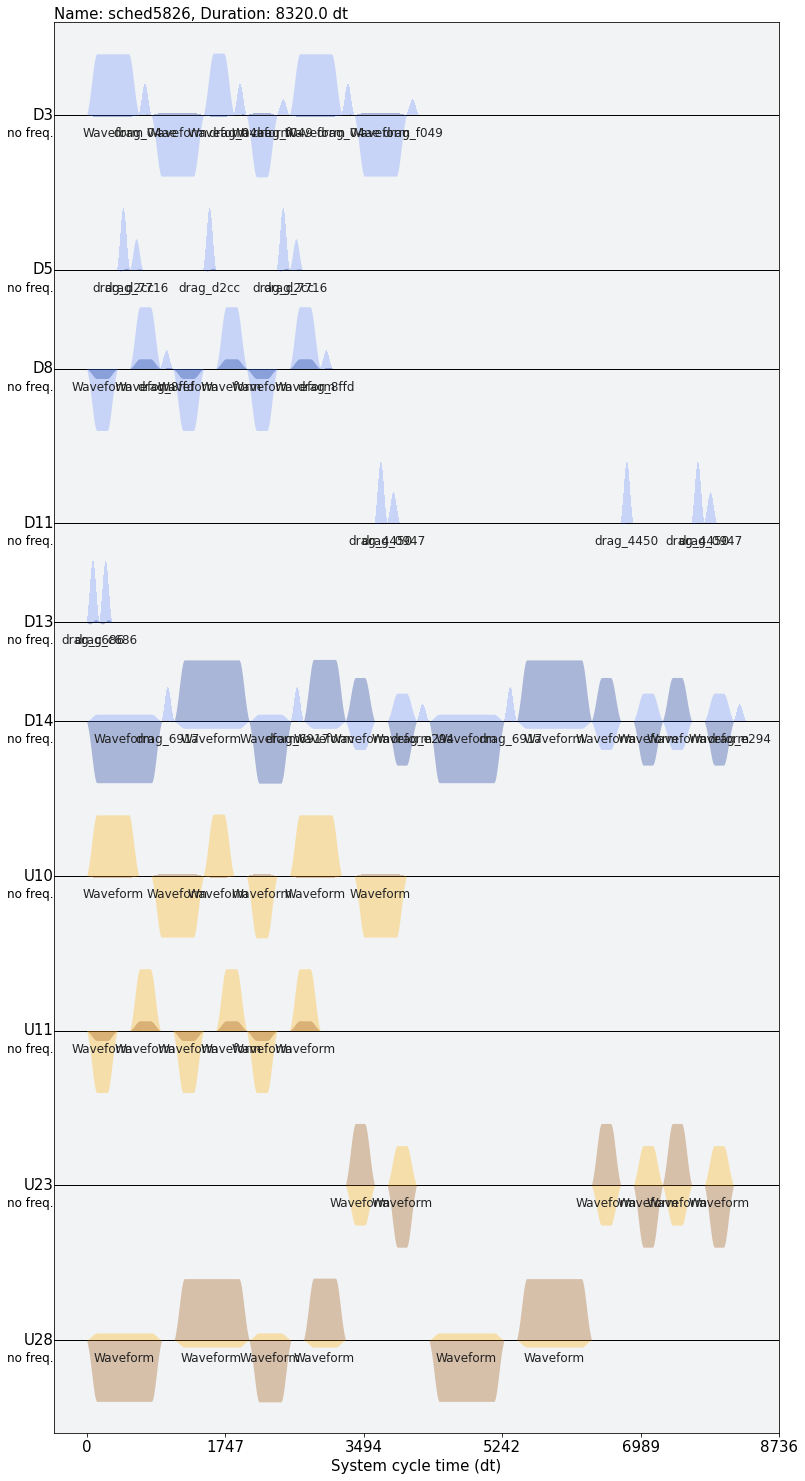

In [72]:
# a plain new schedule
main_sched = Schedule()

#######################################################
# 1. start_sched comes here
#######################################################
# 2. first swapping comes here
#######################################################

# FURTHES NEIGHBORS AND GET THE FULL PI/2 CR PULSE!

# CR(pi/2) for outer qubit pairs: 
main_sched += CR_pi_2.get((q0,q1))
main_sched += CR_pi_2.get((q4,q5))

#######################################################
# 3. first back swapping comes here
#######################################################

# CLOSE NEIGHBORS AND WILL GET JUST A PI/4 CR PULSE NOW!

# repeat CR(pi/4) for outer qubit and direct neighbors
main_sched += CR_pi_4.get((q0,q1))
main_sched += CR_pi_4.get((q4,q5))

# repeat CR(pi/4) for inner qubit and direct neighbors
main_sched += CR_pi_4.get((q1,q2))
main_sched += CR_pi_4.get((q3,q4))

# apply single-qubit rotations
for q in [q0,q1,q2]:
    main_sched += get_single_X_rotation_sched(theta, q, backend, initial_layout)

for q in [q3,q4,q5]:
    main_sched += get_single_X_rotation_sched(beta, q, backend, initial_layout)

#######################################################
# 4. second swapping comes here 
#######################################################

# FURTHES NEIGHBORS AND GET THE FULL PI/2 CR PULSE!

# CR(pi/2) for outer qubit pairs
main_sched += CR_pi_2.get((q0,q1))
main_sched += CR_pi_2.get((q4,q5))

#######################################################
# 5. second back swapping comes here
#######################################################

# CLOSE NEIGHBORS AND WILL GET JUST A PI/4 CR PULSE NOW!

# repeat CR(pi/4) for outer qubit and direct neighbors
main_sched += CR_pi_4.get((q1,q2))
main_sched += CR_pi_4.get((q3,q4))

# repeat CR(theta) for inner qubit and direct neighbors
main_sched += CR_pi_4.get((q1,q2))
main_sched += CR_pi_4.get((q3,q4))

# apply single-qubit rotations
for q in [q0,q1,q2]:
    main_sched += get_single_X_rotation_sched(theta, q, backend, initial_layout)

for q in [q3,q4,q5]:
    main_sched += get_single_X_rotation_sched(beta, q, backend, initial_layout)
    
#######################################################
# 6. end_sched comes here
#######################################################   
    
main_sched.draw()

Wow, that's pretty! Okay, we are going to leave you to it now!

**Have a ton of scrambling fun!**